In [1]:
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import sigmoid, predict, sigmoid_cross_entropy_with_logits, sigmoid_cross_entropy_with_x_w, sigmoid_cross_entropy_truncated, derivative_cost_wrt_params, backtracking_line_search, check_wolfe_II, check_goldstein

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

In [3]:
csv_path = r"C:\Users\Thanh\Downloads\voice_gender\voice.csv"

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [6]:
df['label']=df['label'].replace({'male':1,'female':0})

In [7]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


In [8]:
x = df.drop("label", axis=1).to_numpy(dtype=np.float)
y = df["label"].values.astype(np.float)

In [9]:
x = (x - np.min(x, axis=0, keepdims=True))/(np.max(x, axis=0, keepdims=True) - np.min(x, axis=0, keepdims=True))
#x = (x-np.mean(x, axis=0, keepdims=True))/np.std(x, axis=0, keepdims=True)

In [10]:
x

array([[9.64185977e-02, 4.73408557e-01, 8.41252523e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.25828039e-01, 5.05074648e-01, 1.16899775e-01, ...,
        2.14438885e-03, 2.14592275e-03, 5.64489929e-02],
       [1.79222164e-01, 6.75535813e-01, 1.02872692e-01, ...,
        3.57398142e-04, 3.57653791e-04, 4.98851565e-02],
       ...,
       [4.84948580e-01, 7.99042208e-01, 6.90336544e-01, ...,
        1.34024303e-01, 1.34120172e-01, 2.08884632e-01],
       [4.92516043e-01, 7.45692037e-01, 6.95311295e-01, ...,
        1.64045747e-01, 1.64163090e-01, 3.33559435e-01],
       [5.95699639e-01, 7.68963896e-01, 6.87590032e-01, ...,
        2.50178699e-02, 2.50357654e-02, 3.75385802e-01]])

In [11]:
x.shape

(3168, 20)

In [12]:
ones = np.ones(shape=[x.shape[0], 1], dtype=np.float)
x = np.append(x, ones, axis=1)
x.shape

(3168, 21)

In [13]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)

5

In [14]:
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [15]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2535, 21), (633, 21), (2535,), (633,))

In [16]:
#weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1] + 1)), size=x.shape[1])
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)

In [17]:
weights

array([ 0.61658874, -0.01039898,  0.09248223,  0.05410369,  0.27724507,
        0.54646995, -0.11630061,  0.03552232,  0.16781429, -0.7140504 ,
        0.03789127, -0.07672171,  0.137265  ,  0.2031156 ,  0.1929473 ,
        0.02439308,  0.04182907, -0.33505094, -0.13343636, -0.23270158,
        0.        ])

In [18]:
learning_rate = 5

In [19]:
derivative_cost_wrt_params(x=x, w=weights, y=y).shape

(21,)

In [20]:
sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)

0.7826895279213142

In [21]:
val_cost_list = {}
val_acc_list = {}

In [22]:
train_cost_list = {}
train_acc_list = {}

In [23]:
wolfe_II_list = {}
goldstein_list = {}

In [24]:
x = x_train
y = y_train
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["gd"] = []
val_acc_list["gd"] = []

train_cost_list["gd"] = []
train_acc_list["gd"] = []

wolfe_II_list["gd"] = []
goldstein_list["gd"] = []


for i in range(10000):
    dweights = derivative_cost_wrt_params(x=x, w=weights, y=y)
    #print("dweights: {}".format(dweights))
    #dweights = np.linalg.norm(dweights)
    #if i % 1000 == 0:
    #    learning_rate *= 0.9
    #weights -= learning_rate * dweights
    alpha = backtracking_line_search(x=x, w=weights, y=y, p=-dweights, rho=0.9, alpha=10, c=0.0001)
    wolfe_II_list["gd"].append(check_wolfe_II(x=x, w=weights, y=y, alpha=alpha, p=-dweights, c_2=0.9))
    goldstein_list["gd"].append(check_goldstein(x=x, w=weights, y=y, alpha=alpha, p=-dweights, c=0.25))
    weights -= alpha * dweights
    #print("Alpha: {}".format(alpha))
    #print(weights)
    cost = sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_test, w=weights, y=y_test)
    #output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    #acc = (output == y).sum()/y.shape[0]
    tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y).sum()/y.shape[0]
    val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_test).sum()/y_test.shape[0]

    val_cost_list["gd"].append(val_cost)
    val_acc_list["gd"].append(val_acc)

    train_cost_list["gd"].append(cost)
    train_acc_list["gd"].append(tr_acc)

    #print(output == y)
    #print(cost, acc)
    print(cost, val_cost, tr_acc, val_acc, patience)
    if val_cost < min_val_cost:
        min_val_cost = val_cost
        patience = 0
        max_weights = weights
    else:
        patience += 1

    #if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    if patience >= 20:
        weights = max_weights
        print("Stop at epoch {}, restore weights".format(i))
        break


tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
tr_acc = (tr_output == y).sum()/y.shape[0]
val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
val_acc = (val_output == y_test).sum()/y_test.shape[0]
print(cost, val_cost, tr_acc, val_acc)
print(dweights, np.linalg.norm(dweights))

0.7683700415973124 0.7660948839792556 0.49980276134122287 0.5007898894154819 0
0.7441406039576547 0.7324554532143935 0.5001972386587771 0.5007898894154819 0
0.7290554290531481 0.747468196674941 0.49980276134122287 0.5007898894154819 0
0.7019276511445449 0.712164279914069 0.5384615384615384 0.5165876777251185 1
0.6856536260899969 0.7187316121541804 0.49980276134122287 0.5007898894154819 0
0.6546408665151601 0.6817866911618472 0.7195266272189349 0.6113744075829384 1
0.6361531643606103 0.6794346669583827 0.5029585798816568 0.5007898894154819 0
0.6059604705381259 0.6455020631322336 0.8177514792899409 0.7661927330173776 0
0.5869277314288938 0.6370528820614862 0.5234714003944774 0.5165876777251185 0
0.5611012207949269 0.6091360504007705 0.8504930966469428 0.8278041074249605 0
0.5434652440158595 0.5980034556114894 0.5566074950690335 0.5165876777251185 0
0.540498050554397 0.5946488190196624 0.8564102564102564 0.8325434439178515 0
0.5396202215546645 0.5997230363881816 0.5637080867850098 0.51816

In [25]:
weights

array([  1.50416056,   1.83141692,  -2.08582488,  -2.50552912,
         3.86702852,   7.21693554,  -1.61930272,  -1.2905761 ,
         5.93951115,  -5.00065453,   0.53874952,   0.8108501 ,
       -24.04464755,   2.89246077,  -0.44739086,   0.43970364,
         0.93214911,   0.11933055,   0.30335837,  -0.59291128,
         4.44935299])

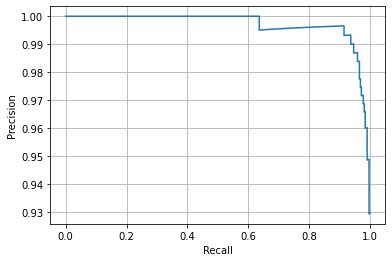

In [26]:
val_prob = predict(x=x_test, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_test, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

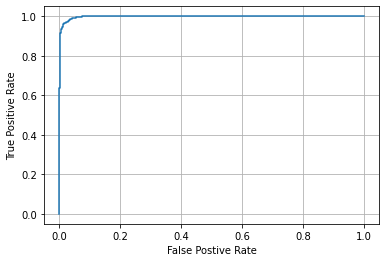

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=100, ).fit(x, y)

val_prob = clf.predict_proba(x_test)
val_predict = np.argmax(val_prob, axis=1)
val_acc = (val_predict == y_test).sum()/y_test.shape[0]

val_acc

0.9684044233807267

In [29]:
num_epochs = 1000
batch_size = 64
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["batch"] = []
val_acc_list["batch"] = []

train_cost_list["batch"] = []
train_acc_list["batch"] = []

wolfe_II_list["batch"] = []
goldstein_list["batch"] = []

for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)

        wolfe_II_list["batch"].append(check_wolfe_II(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c_2=0.9))
        goldstein_list["batch"].append(check_goldstein(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c=0.25))
        #print(alpha)
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_test, w=weights, y=y_test)
    val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_test).sum()/y_test.shape[0]

    val_cost_list["batch"].append(val_cost)
    val_acc_list["batch"].append(val_acc)

    train_cost_list["batch"].append(cost)
    train_acc_list["batch"].append(tr_acc)

    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.593496378518412 0.5743589743589743 0.6361796508907955 0.5165876777251185
1 0.5525120702922821 0.642603550295858 0.6090179409948038 0.5513428120063191
2 0.523046896768824 0.7025641025641025 0.5884378144799305 0.6066350710900474
3 0.49974463191963336 0.7072978303747535 0.5713745375027146 0.6097946287519748
4 0.4817038650966984 0.7353057199211045 0.5571318001385115 0.6524486571879937
5 0.4666116022865098 0.7238658777120316 0.5445500365716222 0.6224328593996841
6 0.4527698525745864 0.749112426035503 0.5322086380992316 0.6951026856240127
7 0.4407994322071974 0.7487179487179487 0.5209480567861864 0.6856240126382307
8 0.4300267322146216 0.762130177514793 0.510499917440517 0.721958925750395
9 0.42050264357654216 0.7546351084812624 0.50082404379625 0.6998420221169036
10 0.4112683620615722 0.7869822485207101 0.4913517487497535 0.7535545023696683
11 0.40250072105638407 0.7854043392504931 0.4820388242921348 0.7456556082148499
12 0.3947587336291355 0.8122287968441815 0.47373335459180266 0.78357

In [30]:
weights

array([  1.30601417,   1.92394753,  -1.54327982,  -2.29420141,
         3.84336593,   6.58133761,  -1.18046228,  -1.29674821,
         5.31347757,  -4.25474206,   0.57927581,   0.76561866,
       -22.07214849,   2.32842493,  -0.48326588,   0.49145086,
         0.6913181 ,   0.09817529,   0.32330799,  -0.55740126,
         3.55228251])

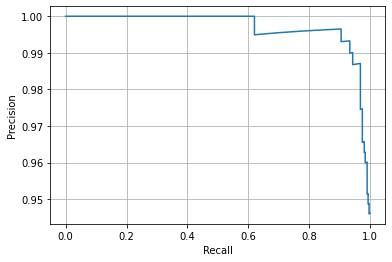

In [31]:
val_prob = predict(x=x_test, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_test, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

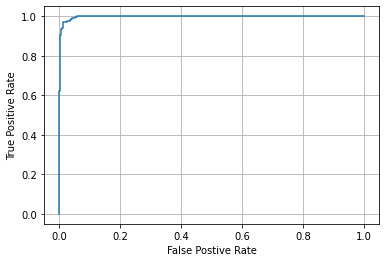

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [33]:
num_epochs = 500
batch_size = 1
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["sgd"] = []
val_acc_list["sgd"] = []

train_cost_list["sgd"] = []
train_acc_list["sgd"] = []

wolfe_II_list["sgd"] = []
goldstein_list["sgd"] = []


for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)
        #print(alpha)

        wolfe_II_list["sgd"].append(check_wolfe_II(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c_2=0.9))
        goldstein_list["sgd"].append(check_goldstein(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c=0.25))
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_test, w=weights, y=y_test)
    val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_test).sum()/y_test.shape[0]

    val_cost_list["sgd"].append(val_cost)
    val_acc_list["sgd"].append(val_acc)

    train_cost_list["sgd"].append(cost)
    train_acc_list["sgd"].append(tr_acc)


    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.6088755152236868 0.545956607495069 0.6507371667438234 0.5102685624012638
1 0.5844194993920128 0.5455621301775148 0.6540397869187043 0.5086887835703001
2 0.5447892934045135 0.7846153846153846 0.6162362621081147 0.69826224328594
3 0.5100149503596909 0.7187376725838265 0.5854903851319422 0.6145339652448657
4 0.5257745914455524 0.6122287968441814 0.6109671113408023 0.5418641390205371
5 0.4845652958833822 0.8149901380670611 0.5675391830968181 0.7440758293838863
6 0.4621908136656405 0.7021696252465484 0.5477758689166808 0.6097946287519748
7 0.5364753067782131 0.6031558185404339 0.6262360106027287 0.5323854660347551
8 0.44244251038313304 0.8378698224852071 0.5315754217835028 0.7630331753554502
9 0.4292190843857377 0.7270216962524655 0.5154170633103473 0.6303317535545023
10 0.4187750743243435 0.7392504930966469 0.5020907169752095 0.6445497630331753
11 0.4337457456525933 0.895069033530572 0.5206766163836124 0.8515007898894155
12 0.40522572815015223 0.8591715976331361 0.49546965929185044 0.7

In [34]:
weights, dweights

(array([  1.20906984,   1.57412585,  -0.59246232,  -2.37022539,
          3.9129938 ,   6.15486929,  -0.9055365 ,  -0.81366487,
          4.06376372,  -2.85201797,   0.74745752,   1.3107782 ,
        -18.98122207,   1.62810924,  -0.70567728,   0.90339154,
          0.35338261,   0.58640628,  -0.16686458,  -0.33610829,
          2.15081721]),
 array([-0.59694753, -0.21279667, -0.62696442, -0.60947475, -0.62991203,
        -0.05821789, -0.05835203, -0.00679724, -0.33610857, -0.0793132 ,
        -0.57317853, -0.59694753, -0.30934476, -0.07769934, -0.67060425,
        -0.20614737, -0.00440791, -0.17898674, -0.17911477, -0.12944855,
        -0.68322633]))

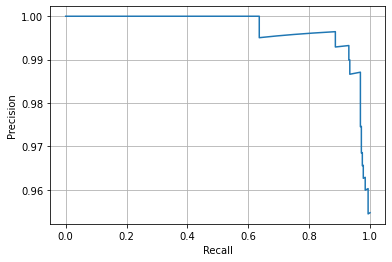

In [35]:
val_prob = predict(x=x_test, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_test, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

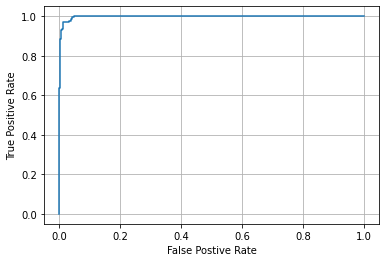

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

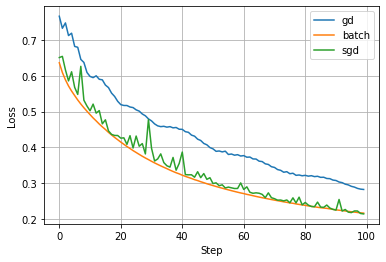

In [37]:
for method in val_cost_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), val_cost_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

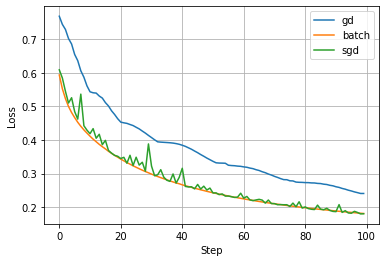

In [38]:
for method in train_cost_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), train_cost_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

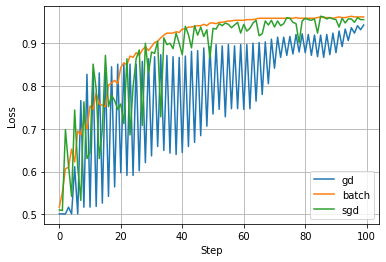

In [39]:
for method in val_acc_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), val_acc_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

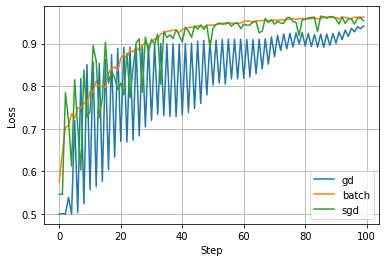

In [40]:
for method in train_acc_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), train_acc_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [41]:
wolfe_II_list

{'gd': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  

In [42]:
goldstein_list

{'gd': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  Fa